<center><h1>Chen_WeiChieh_Project</h1></center>

### Due to the high training time for this project and my 1st result of CNN+MLP is not good, I re-run the CNN+MLP model by adding a RandomFlip and a dense layer with 64 perceptrons. Hence, my work is divided into 2 files. This file pertains to "CNN+MCP".

### Please only see CNN+MLP part in this file, and refer to the cell denoting "All the work of this file stops here".

Name: WeiChieh, Chen
<br>
Github Username: raychencssw
<br>
USC ID: 6284920085

# 1

In [ ]:
from keras.models import load_model

# Load the entire model
model = load_model('weights_res.h5')

# Print model summary
model.summary()

In [9]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io


In [10]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
#print(subdirs) 
#PosixPath('ESP_026602_1300_25600_30720_5120_10240'), ....

src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]
# print(src_image_ids)
#['ESP_026602_1300',

In [11]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# print(len(subdir_splits))  # 214
# print(subdir_splits)       # ['test', 'train', ...]

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [12]:
import random
import tensorflow as tf
from PIL import Image 


def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')

        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        # Normalize the image to the [0, 1] range
        img = img / 255.0
        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([]) # Scalar label
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    # dir_path: ./data/ESP_026602_1300_25600_30720_5120_10240

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    # tile_dir: ./data/ESP_026602_1300_25600_30720_5120_10240/tiles
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    # folder: frost or background
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            # file: PSP_008120_2465_70447_70746_7811_8110.png
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    # (./data/ESP_026602_1300_25600_30720_5120_10240/tiles/frost/PSP_008120_2465_70447_70746_7811_8110.png, frost)
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements

buffer_size = 64         #11s
batch_size = 32


# buffer_size = 119920   #75m
# batch_size = 128

# buffer_size = 256        #47m
# batch_size = 128

# subdirs: PosixPath('ESP_026602_1300_25600_30720_5120_10240'), ....
# subdir_splits: ['test', 'train', ...]  len:214
for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

# training data        

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)
#print(img_list_t)
#tf.Tensor([b'data/PSP_008120_2465_66560_71680_5120_10240/tiles/frost/PSP_008120_2465_69849_70148_9306_9605.png']..., shape=(14119,), dtype=string)


tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
# print(tf_dataset_train)

# tf.data.experimental.AUTOTUNE: representing the number elements to process asynchronously in parallel
# load_and_preprocess: converts the label to a binary format (1 if 'frost', 0 otherwise)
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# tf_dataset_train = tf_dataset_train.map(rotate_train)
# print(len(list(tf_dataset_train))) # 14119
# print(tf_dataset_train)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 
# print(len(list(tf_dataset_train))) # 442
# print(tf_dataset_train)

# validation data 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# print(len(list(tf_dataset_val))) # 7889
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 
# print(len(list(tf_dataset_val))) # 247

# test data 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# len(list(tf_dataset_test))
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 
# len(list(tf_dataset_test)) # 250

In [13]:
for img, label in tf_dataset_train.take(1):
    print(img.shape)
    print(img[0][0][0])
    print(len(label))
    print(label)

(32, 299, 299, 3)
tf.Tensor([0.2627451 0.2627451 0.2627451], shape=(3,), dtype=float32)
32
tf.Tensor([1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1], shape=(32,), dtype=int64)


# Traning CNN + MLP
### i Empirical Regularization

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, RandomRotation,  RandomFlip
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.models import Model
import matplotlib.pyplot as plt

### ii Train a three-layer CNN

In [20]:
def build_cnn():
    # Define the model
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299,299,3), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(RandomRotation(factor=(-1,1),seed=SEED))
    # model.add(RandomContrast(factor=(0.2),seed=SEED))
    model.add(RandomFlip(seed=SEED))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Add the output layer with softmax activation
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    return model

model = build_cnn()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(tf_dataset_train, epochs=30, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(tf_dataset_test)

print(f'Test accuracy: {test_acc}')


# 415m

Epoch 1/30
442/442 [==============================] - 993s 2s/step - loss: 0.2467 - accuracy: 0.9108 - val_loss: 0.6363 - val_accuracy: 0.8800
Epoch 2/30
442/442 [==============================] - 1079s 2s/step - loss: 0.1457 - accuracy: 0.9456 - val_loss: 1.3101 - val_accuracy: 0.5087
Epoch 3/30
442/442 [==============================] - 1190s 3s/step - loss: 0.2021 - accuracy: 0.9252 - val_loss: 0.9602 - val_accuracy: 0.8725
Epoch 4/30
442/442 [==============================] - 1195s 3s/step - loss: 0.1617 - accuracy: 0.9410 - val_loss: 0.1863 - val_accuracy: 0.9627
Epoch 5/30
442/442 [==============================] - 1183s 3s/step - loss: 0.1281 - accuracy: 0.9547 - val_loss: 0.7611 - val_accuracy: 0.7162
Epoch 6/30
442/442 [==============================] - 1092s 2s/step - loss: 0.1119 - accuracy: 0.9595 - val_loss: 0.5780 - val_accuracy: 0.7657
Epoch 7/30
442/442 [==============================] - 1184s 3s/step - loss: 0.1025 - accuracy: 0.9632 - val_loss: 6.0178 - val_accuracy: 

In [21]:
# Save the entire model to a file
model.save('model.h5')

# Save only the weights to a separate file
model.save_weights('weights.h5')

/Users/Ray/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# print(model.summary())

### iii Report Precision, Recall, and F1-score

In [23]:
# model.predict_classes is deprecated
y_pred = model.predict(tf_dataset_test)

250/250 [==============================] - 127s 505ms/step


In [24]:
# convert the predicted probability to predicted class
y_pred_class = np.argmax(y_pred, axis=1)
print(len(y_pred_class))
print(y_pred_class)

# extract the true label from the batched dataset
y_true = []
for img, labels in tf_dataset_test:
    # print(label)
    for label in labels:
        y_true.append(label)
print(len(y_true))

7972
[1 0 0 ... 0 0 0]


7972


In [25]:
report = classification_report(y_true, y_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.28      0.49      0.35      2198
           1       0.73      0.51      0.60      5774

    accuracy                           0.50      7972
   macro avg       0.50      0.50      0.48      7972
weighted avg       0.60      0.50      0.53      7972



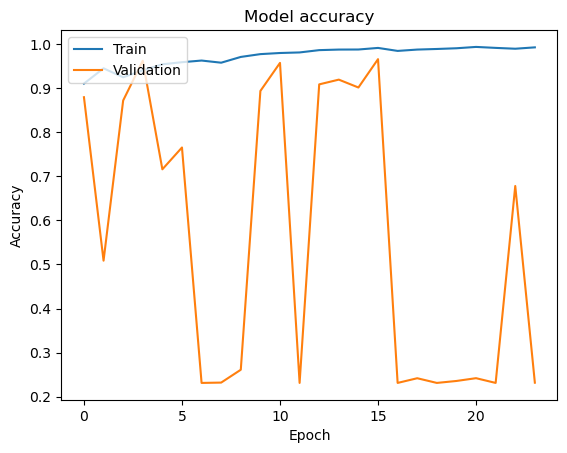

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

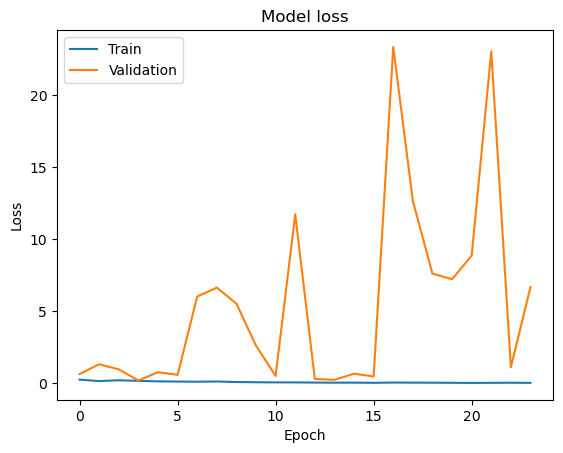

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### All the work of this file stops here

# Transfer Learning

### EfficientNetB0

In [28]:
from keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [29]:
#build a EfficientNetB0 without top layer and freeze the feature extraction layers
model_eff = EfficientNetB0(include_top=False, input_shape = (299,299,3))
for layer in model_eff.layers:
    layer.trainable = False

# model_eff.summary()

In [49]:

model_eff_retrain = Sequential()

model_eff_retrain.add(model_eff)   


model_eff_retrain.add(RandomRotation(factor=(-1,1),seed=SEED))
model_eff_retrain.add(RandomFlip(seed=SEED))

model_eff_retrain.add(Flatten())

model_eff_retrain.add(Dense(64, activation='relu'))
model_eff_retrain.add(BatchNormalization())
model_eff_retrain.add(Dropout(0.3))

model_eff_retrain.add(Dense(2, activation='softmax'))

model_eff_retrain.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_eff = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_eff = model_eff_retrain.fit(tf_dataset_train, epochs=15, validation_data=tf_dataset_val, callbacks=[early_stopping_eff])


# 92m(7 epochs)

Epoch 1/15
442/442 [==============================] - 560s 1s/step - loss: 0.7170 - accuracy: 0.6019 - val_loss: 1.0291 - val_accuracy: 0.2310
Epoch 2/15
442/442 [==============================] - 655s 1s/step - loss: 0.6594 - accuracy: 0.6373 - val_loss: 1.0420 - val_accuracy: 0.2310
Epoch 3/15
442/442 [==============================] - 781s 2s/step - loss: 0.6500 - accuracy: 0.6483 - val_loss: 0.9933 - val_accuracy: 0.2310
Epoch 4/15
442/442 [==============================] - 800s 2s/step - loss: 0.6485 - accuracy: 0.6500 - val_loss: 1.1198 - val_accuracy: 0.2310
Epoch 5/15
442/442 [==============================] - 834s 2s/step - loss: 0.6480 - accuracy: 0.6502 - val_loss: 0.9255 - val_accuracy: 0.2310
Epoch 6/15
442/442 [==============================] - 785s 2s/step - loss: 0.6469 - accuracy: 0.6498 - val_loss: 0.9009 - val_accuracy: 0.2310
Epoch 7/15
442/442 [==============================] - 778s 2s/step - loss: 0.6466 - accuracy: 0.6490 - val_loss: 0.9237 - val_accuracy: 0.2310

In [50]:
# Save the entire model to a file
model_eff_retrain.save('model_eff.h5')

# Save only the weights to a separate file
model_eff_retrain.save_weights('weights_eff.h5')

/Users/Ray/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
# model.predict_classes is deprecated
y_pred_eff = model_eff_retrain.predict(tf_dataset_test)

# convert the predicted probability to predicted class
y_pred_eff_class = np.argmax(y_pred_eff, axis=1)
print(len(y_pred_eff_class))
print(y_pred_eff_class)

# extract the true label from the batched dataset
y_true = []
for img, labels in tf_dataset_test:
    # print(label)
    for label in labels:
        y_true.append(label)
print(len(y_true))


#30m

250/250 [==============================] - 311s 1s/step
7972
[1 1 1 ... 1 1 1]
7972


In [52]:
report_eff = classification_report(y_true, y_pred_eff_class)
print(report_eff)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2198
           1       0.72      1.00      0.84      5774

    accuracy                           0.72      7972
   macro avg       0.36      0.50      0.42      7972
weighted avg       0.52      0.72      0.61      7972



/Users/Ray/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Ray/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Ray/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
# Evaluate the model on the test set
test_loss_eff, test_acc_eff = model_eff_retrain.evaluate(tf_dataset_test)

print(f'Test accuracy: {test_acc_eff}')

250/250 [==============================] - 307s 1s/step - loss: 0.5984 - accuracy: 0.7243
Test accuracy: 0.7242850065231323


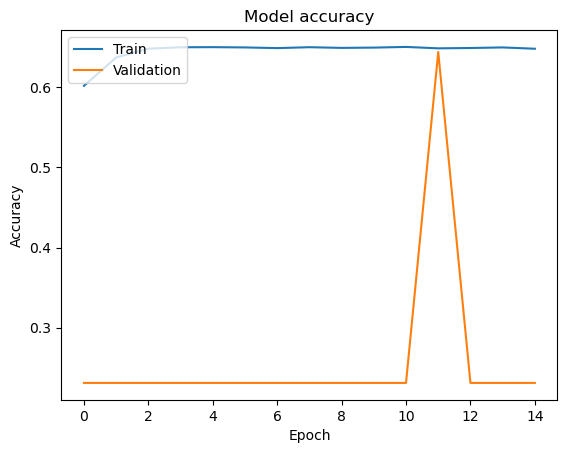

In [54]:
plt.plot(history_eff.history['accuracy'])
plt.plot(history_eff.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

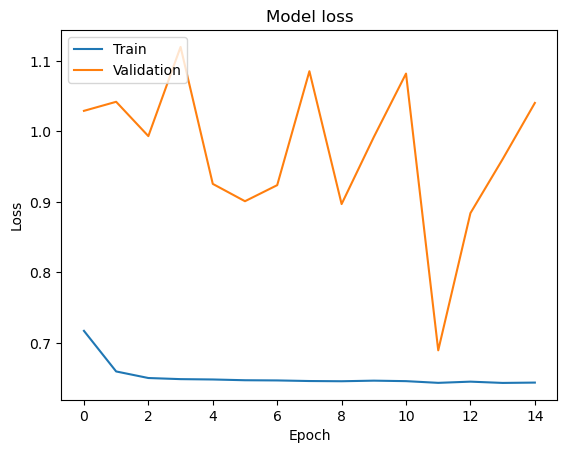

In [55]:
plt.plot(history_eff.history['loss'])
plt.plot(history_eff.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### ResNet50

In [56]:
from keras.applications import ResNet50

In [57]:
#build a ResNet50 without top layer and freeze the feature extraction layers
model_res = ResNet50(include_top=False, input_shape = (299,299,3))
for layer in model_res.layers:
    layer.trainable = False

In [59]:
model_res_retrain = Sequential()

model_res_retrain.add(model_res)   

model_res_retrain.add(RandomRotation(factor=(-1,1),seed=SEED))
model_res_retrain.add(RandomFlip(seed=SEED))

model_res_retrain.add(Flatten())

model_res_retrain.add(Dense(64, activation='relu'))
model_res_retrain.add(BatchNormalization())
model_res_retrain.add(Dropout(0.3))

model_res_retrain.add(Dense(2, activation='softmax'))

model_res_retrain.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_res = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_res = model_res_retrain.fit(tf_dataset_train, epochs=15, validation_data=tf_dataset_val, callbacks=[early_stopping_res])


#210m(6 epochs)

Epoch 1/15
442/442 [==============================] - 2083s 5s/step - loss: 0.5898 - accuracy: 0.7024 - val_loss: 1.0948 - val_accuracy: 0.3057
Epoch 2/15
442/442 [==============================] - 2297s 5s/step - loss: 0.4513 - accuracy: 0.7933 - val_loss: 0.4229 - val_accuracy: 0.8307
Epoch 3/15
442/442 [==============================] - 2224s 5s/step - loss: 0.4094 - accuracy: 0.8170 - val_loss: 0.4959 - val_accuracy: 0.7853
Epoch 4/15
442/442 [==============================] - 2061s 5s/step - loss: 0.3748 - accuracy: 0.8352 - val_loss: 1.0623 - val_accuracy: 0.4013
Epoch 5/15
442/442 [==============================] - 2078s 5s/step - loss: 0.3552 - accuracy: 0.8481 - val_loss: 1.6901 - val_accuracy: 0.2895
Epoch 6/15
442/442 [==============================] - 1841s 4s/step - loss: 0.3471 - accuracy: 0.8513 - val_loss: 0.5990 - val_accuracy: 0.6893
Epoch 7/15
442/442 [==============================] - 2135s 5s/step - loss: 0.3335 - accuracy: 0.8593 - val_loss: 1.0074 - val_accuracy:

In [60]:
# Save the entire model to a file
model_res_retrain.save('model_res.h5')

# Save only the weights to a separate file
model_res_retrain.save_weights('weights_res.h5')

/Users/Ray/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


OSError: Unable to create file (file signature not found)

In [ ]:
# model.predict_classes is deprecated
y_pred_res = model_res_retrain.predict(tf_dataset_test)

# convert the predicted probability to predicted class
y_pred_res_class = np.argmax(y_pred_res, axis=1)
print(len(y_pred_res_class))
print(y_pred_res_class)

# extract the true label from the batched dataset
y_true = []
for img, labels in tf_dataset_test:
    # print(label)
    for label in labels:
        y_true.append(label)
print(len(y_true))

#12m

250/250 [==============================] - 796s 3s/step
7972
[0 1 1 ... 1 0 0]
7972


In [ ]:
report_res = classification_report(y_true, y_pred_res_class)
print(report_res)

              precision    recall  f1-score   support

           0       0.28      0.64      0.38      2198
           1       0.72      0.36      0.48      5774

    accuracy                           0.44      7972
   macro avg       0.50      0.50      0.43      7972
weighted avg       0.60      0.44      0.46      7972



In [ ]:
# Evaluate the model on the test set
test_loss_res, test_acc_res = model_res_retrain.evaluate(tf_dataset_test)

print(f'Test accuracy: {test_acc_res}')

250/250 [==============================] - 807s 3s/step - loss: 0.9847 - accuracy: 0.4166
Test accuracy: 0.41658303141593933


In [ ]:
print(f'Test accuracy: {test_acc_res}')

Test accuracy: 0.41658303141593933


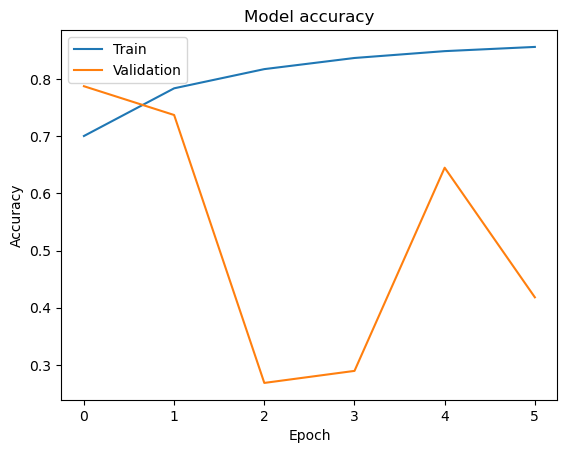

In [ ]:
plt.plot(history_res.history['accuracy'])
plt.plot(history_res.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

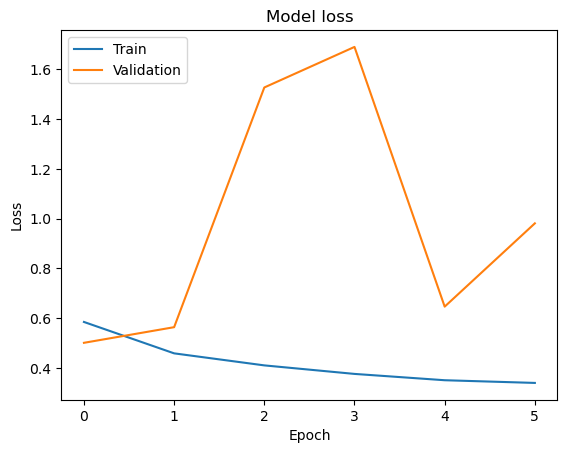

In [ ]:
plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### VGG16

In [ ]:
from keras.applications import VGG16

In [ ]:
#build a VGG16 without top layer and freeze the feature extraction layers
model_vgg = VGG16(include_top=False, input_shape = (299,299,3))
for layer in model_vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
model_vgg_retrain = Sequential()

model_vgg_retrain.add(model_vgg)   

model_vgg_retrain.add(RandomRotation(factor=(-1,1),seed=SEED))
model_eff_retrain.add(RandomFlip(seed=SEED))

model_vgg_retrain.add(Flatten())

model_vgg_retrain.add(Dense(64, activation='relu'))
model_vgg_retrain.add(BatchNormalization())
model_vgg_retrain.add(Dropout(0.3))

model_vgg_retrain.add(Dense(2, activation='softmax'))

model_vgg_retrain.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_vgg = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_vgg = model_vgg_retrain.fit(tf_dataset_train, epochs=15, validation_data=tf_dataset_val, callbacks=[early_stopping_vgg])

# 24H

Epoch 1/15
442/442 [==============================] - 5810s 13s/step - loss: 0.1015 - accuracy: 0.9641 - val_loss: 2.6354 - val_accuracy: 0.4633
Epoch 2/15
442/442 [==============================] - 5787s 13s/step - loss: 0.0560 - accuracy: 0.9785 - val_loss: 2.1241 - val_accuracy: 0.5586
Epoch 3/15
442/442 [==============================] - 5751s 13s/step - loss: 0.0441 - accuracy: 0.9840 - val_loss: 1.2508 - val_accuracy: 0.6775
Epoch 4/15
442/442 [==============================] - 5728s 13s/step - loss: 0.0479 - accuracy: 0.9831 - val_loss: 2.2301 - val_accuracy: 0.4830
Epoch 5/15
442/442 [==============================] - 5770s 13s/step - loss: 0.0398 - accuracy: 0.9856 - val_loss: 2.1632 - val_accuracy: 0.5226
Epoch 6/15
442/442 [==============================] - 6486s 15s/step - loss: 0.0340 - accuracy: 0.9880 - val_loss: 2.4086 - val_accuracy: 0.4987
Epoch 7/15
442/442 [==============================] - 6655s 15s/step - loss: 0.0394 - accuracy: 0.9865 - val_loss: 2.4220 - val_ac

In [ ]:
# Save the entire model to a file
model_vgg_retrain.save('model_vgg.h5')

# Save only the weights to a separate file
model_vgg_retrain.save_weights('weights_vgg.h5')

/Users/Ray/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# model.predict_classes is deprecated
y_pred_vgg = model_vgg_retrain.predict(tf_dataset_test)

# convert the predicted probability to predicted class
y_pred_vgg_class = np.argmax(y_pred_vgg, axis=1)
print(len(y_pred_vgg_class))
print(y_pred_vgg_class)

# extract the true label from the batched dataset
y_true = []
for img, labels in tf_dataset_test:
    # print(label)
    for label in labels:
        y_true.append(label)
print(len(y_true))

250/250 [==============================] - 2755s 11s/step
7972
[0 1 1 ... 1 1 1]
7972


In [ ]:
report_vgg = classification_report(y_true, y_pred_vgg_class)
print(report_vgg)

              precision    recall  f1-score   support

           0       0.29      0.38      0.33      2198
           1       0.73      0.64      0.68      5774

    accuracy                           0.57      7972
   macro avg       0.51      0.51      0.50      7972
weighted avg       0.61      0.57      0.58      7972



In [ ]:
# Evaluate the model on the test set
test_loss_vgg, test_acc_vgg = model_vgg_retrain.evaluate(tf_dataset_test)

print(f'Test accuracy: {test_acc_vgg}')

# 05m

2023-12-10 12:48:03.667033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 52 of 64
2023-12-10 12:48:04.919992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 2996s 12s/step - loss: 0.7027 - accuracy: 0.8258
Test accuracy: 0.8257651925086975


In [ ]:
print(f'Test accuracy: {test_acc_vgg}')

Test accuracy: 0.8257651925086975


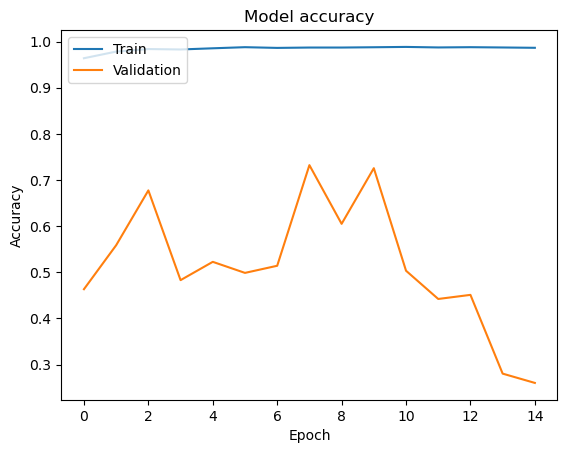

In [ ]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

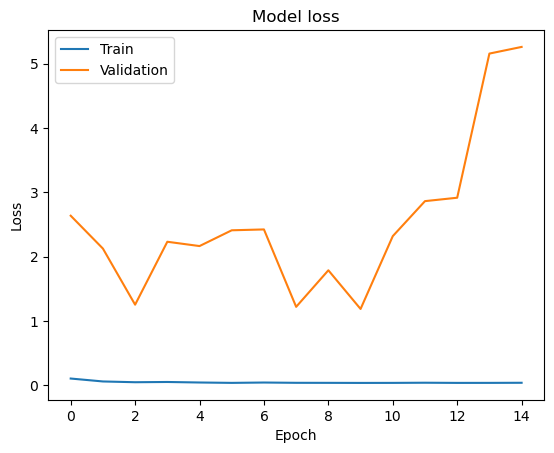

In [ ]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Summary of the models:
- EfficientNetB0 predict every observation as class 1 so it has the worst recall precision for calss 0.
- VGG16 gives the highest test acc while retain OK precision, recall and f1-score.
- None of the models perform well on class 0.
- These pre-trained model use 3 channels, but our data only use 1 channel. Such difference might casue some issue.
- Our handmade CNN+MLP model doesn't work well either, it can result from not many data augmentation and I don't use too many neurons.

In [ ]:
def summary_models(reports, test_accs):
    precision = []
    recall = []
    f1_score = []
    test_acc = []

    # manually append CNN+MLP's result
    # precision.append(0.28)
    # precision.append(0.73)
    # recall.append(0.82)
    # recall.append(0.19)
    # f1_score.append(0.42)
    # f1_score.append(0.3)
    # test_acc.append(0.4559708833694458)
    # test_acc.append(0.4559708833694458)

    for report in reports:
        precision_0 = report.split()[5]
        precision_1 = report.split()[10]
        recall_0 = report.split()[6]
        recall_1 = report.split()[11]
        f1_0 = report.split()[7]
        f1_1 = report.split()[12]
        precision.append(precision_0)
        precision.append(precision_1)
        recall.append(recall_0)
        recall.append(recall_1)
        f1_score.append(f1_0)
        f1_score.append(f1_1)

    for acc in test_accs:
        test_acc.append(acc)
        test_acc.append(acc)
    summary = {'precision':precision, 'recall': recall, 'f1-score': f1_score, 'test_acc':test_acc}
    return summary


In [ ]:
import pandas as pd
test_accs = [test_acc, test_acc_eff, test_acc_res, test_acc_vgg]
reports = [report, report_eff,report_res,report_vgg]
summary = summary_models(reports, test_accs)
print(summary)
index = ['CNN+MLP_class0', 'CNN+MLP_class1','EfficientNetB0_clas0', 'EfficientNetB0_clas1', 'ResNet50_clas0', 'ResNet50_clas1', 'VGG16_clas0', 'VGG16_clas1']
df = pd.DataFrame(summary, index=index)
df

{'precision': [0.28, 0.73, '0.00', '0.72', '0.28', '0.73', '0.29', '0.73'], 'recall': [0.82, 0.19, '0.00', '1.00', '0.69', '0.31', '0.38', '0.64'], 'f1-score': [0.42, 0.3, '0.00', '0.84', '0.40', '0.44', '0.33', '0.68'], 'test_acc': [0.4559708833694458, 0.4559708833694458, 0.7242850065231323, 0.7242850065231323, 0.4024084210395813, 0.4024084210395813, 0.8257651925086975, 0.8257651925086975]}


,precision,recall,f1-score,test_acc
CNN+MLP_class0,0.28,0.82,0.42,0.455971
CNN+MLP_class1,0.73,0.19,0.3,0.455971
EfficientNetB0_clas0,0.00,0.00,0.00,0.724285
EfficientNetB0_clas1,0.72,1.00,0.84,0.724285
ResNet50_clas0,0.28,0.69,0.40,0.402408
ResNet50_clas1,0.73,0.31,0.44,0.402408
VGG16_clas0,0.29,0.38,0.33,0.825765
VGG16_clas1,0.73,0.64,0.68,0.825765
